In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Janvita/Yield_Prediction/models

/content/drive/.shortcut-targets-by-id/1y1kJ8CAnmIoPwnxy4-zCNANS5Ho67goV/models


In [ ]:
#cd /content/drive/MyDrive/models/

/content/drive/MyDrive/models


In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K


def jacard_coef_loss(y_true, y_pred):
    return 1 -jacard_coef(y_true, y_pred)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)  # Cast y_true_f to float32
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.cast(y_pred_f, tf.float32)  # Cast y_pred_f to float32 to ensure type consistency
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 0.00001) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_metric(y_true, y_pred):
    #y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.cast(y_pred_f, tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    dice = (2.0 * intersection + K.epsilon()) / (union + K.epsilon())
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_metric(y_pred, y_true)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
    return K.mean(focal_loss)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)

    # You can adjust the weights to balance the contributions of each loss term
    combined = 0.5 * dice + 0.5 * focal

    return combined




In [ ]:
os.listdir()

['images',
 'unet_vgg16.keras',
 'lr_plots',
 'unet_resnet50.keras',
 'attention_unet.keras']

In [ ]:
os.listdir('images')

['vgg_16', 'vgg16', 'resnet_50', 'attention_unet', 'cbam_unet']

In [ ]:
os.listdir()

In [ ]:
model = tf.keras.models.load_model(
    "unet_resnet50.keras",
    custom_objects={'combined_loss': combined_loss,'jacard_coef':jacard_coef}  # Pass the custom function
)

In [ ]:
#input_dir = "/content/drive/MyDrive/Janvita/Yield_Prediction/Images_5K_JPG"
input_dir = "/content/drive/MyDrive/Janvita/Yield_Prediction/Images_5K_JPG" # Directory with input images
output_dir = "images/resnet_50"

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import os
import numpy as np
import cv2
import time  # Import the time module

batch_size = 16
image_batch = []
filenames_batch = []
total_images = 0
total_inference_time = 0
processed_images = 0  # Counter for processed images

# Limit to first 200 images
max_images = 200

for filename in os.listdir(input_dir):
    if processed_images >= max_images:
        break  # Stop processing after 200 images

    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (160, 160))
    image_batch.append(image)
    filenames_batch.append(filename)

    if len(image_batch) == batch_size or processed_images + len(image_batch) == max_images:
        batch_array = np.array(image_batch)
        start_time = time.time()
        masks = model.predict(batch_array)
        batch_inference_time = time.time() - start_time
        total_inference_time += batch_inference_time
        total_images += len(image_batch)

        # Process masks and save them
        for i, mask in enumerate(masks):
            mask = np.squeeze(mask)
            mask = (mask * 255).astype('uint8')
            mask = cv2.resize(mask, (150, 150))
            mask_path = os.path.join(output_dir, filenames_batch[i])
            cv2.imwrite(mask_path, mask)

        # Print average inference time per image after each batch
        average_inference_time = total_inference_time / total_images
        print(f"Average inference time after processing {total_images} images: {average_inference_time:.4f} seconds")

        image_batch = []
        filenames_batch = []

        processed_images += len(image_batch)

# If there are any remaining images in the batch that haven't been processed
if image_batch:
    batch_array = np.array(image_batch)
    start_time = time.time()
    masks = model.predict(batch_array)
    batch_inference_time = time.time() - start_time
    total_inference_time += batch_inference_time
    total_images += len(image_batch)

    for i, mask in enumerate(masks):
        mask = np.squeeze(mask)
        mask = (mask * 255).astype('uint8')
        mask = cv2.resize(mask, (150, 150))
        mask_path = os.path.join(output_dir, filenames_batch[i])
        cv2.imwrite(mask_path, mask)

    # Print average inference time for the last batch
    average_inference_time = total_inference_time / total_images
    print(f"Average inference time after processing {total_images} images: {average_inference_time:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Average inference time after processing 16 images: 0.4326 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Average inference time after processing 32 images: 0.2230 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average inference time after processing 48 images: 0.1529 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Average inference time after processing 64 images: 0.1180 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Average inference time after processing 80 images: 0.0988 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Average inference time after processing 96 images: 0.0853 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average inference time after processing 112 images: 0.0763 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average inference time after processing 128 images: 0.0683 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Average inference time after processing 144 images: 0.0622 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Average inference time af

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import cv2
import time  # Import the time module
import pandas as pd
import matplotlib.pyplot as plt

batch_size = 16

image_batch = []
filenames_batch = []
total_images = 0
total_inference_time = 0
i = 0

for filename in os.listdir(input_dir):
    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (160, 160))
    image_batch.append(image)
    filenames_batch.append(filename)

    if len(image_batch) == batch_size:
        batch_array = np.array(image_batch)
        start_time = time.time()
        masks = model.predict(batch_array)
        batch_inference_time = time.time() - start_time
        total_inference_time += batch_inference_time
        total_images += batch_size
        for i, mask in enumerate(masks):
            mask = np.squeeze(mask)
            mask = (mask * 255).astype('uint8')
            mask = cv2.resize(mask, (150, 150))
            mask_path = os.path.join(output_dir, filenames_batch[i])
            cv2.imwrite(mask_path, mask)
        image_batch = []
        filenames_batch = []

if image_batch:
    batch_array = np.array(image_batch)
    start_time = time.time()
    masks = model.predict(batch_array)
    batch_inference_time = time.time() - start_time
    total_inference_time += batch_inference_time
    total_images += len(image_batch)
    for i, mask in enumerate(masks):
        mask = np.squeeze(mask)
        mask = (mask * 255).astype('uint8')
        mask = cv2.resize(mask, (150, 150))

        mask_path = os.path.join(output_dir, filenames_batch[i])
        cv2.imwrite(mask_path, mask)
average_inference_time = total_inference_time / total_images
print(f"Average inference time per image: {average_inference_time:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [ ]:
import re

In [ ]:
def extract_number_from_filename(filename):
    match = re.search(r'mosaic(\d+)', filename)
    return int(match.group(1)) if match else 0


In [ ]:
pwd

'/content/drive/MyDrive/models'

In [ ]:
files= os.listdir('images/attention_unet')

In [ ]:
len(files)

5376

In [ ]:
files= os.listdir('images/attention_unet')
files = sorted(files, key=extract_number_from_filename)
data = []
for i in range(len(files)):
  img = cv2.imread('images/attention_unet/' + files[i])
  data.append(img)

data = np.array(data)

In [ ]:
data.shape

(5376, 150, 150, 3)

In [ ]:
num_sets = data.shape[0] // 56

new_data = np.zeros((num_sets, 150 * 8, 150 * 7, 3), dtype=data.dtype)

for i in range(num_sets):
    for j in range(8):
        for k in range(7):
            new_data[i, j * 150 : (j + 1) * 150, k * 150 : (k + 1) * 150, :] = data[i * 56 + j * 7 + k]

print(new_data.shape)

(96, 1200, 1050, 3)


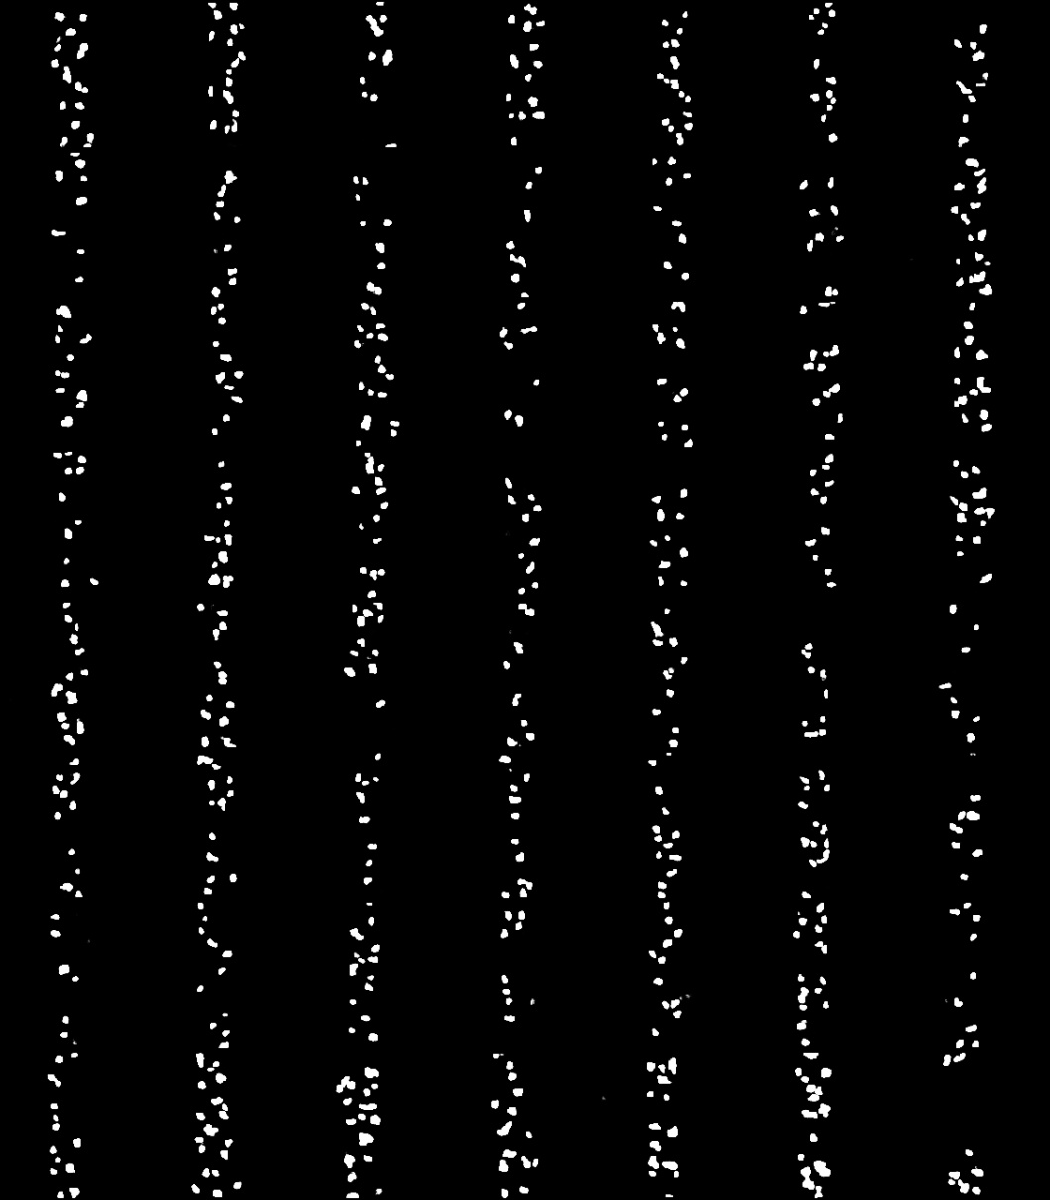

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(new_data[0])

In [ ]:


white = []
threshold_value = 50

for i in range(new_data.shape[0]):
    gray_img = cv2.cvtColor(new_data[i], cv2.COLOR_BGR2GRAY)
    ret, binary_image = cv2.threshold(gray_img, threshold_value, 255, cv2.THRESH_BINARY)

    # Count the white pixels
    n_white_pix = np.sum(binary_image)
    white.append(n_white_pix)


In [ ]:
yield_data = pd.read_csv('/content/drive/MyDrive/my_cotton_yield_data.csv') # lb
total_yield = yield_data['yield']

In [ ]:
total_yield.shape

(96,)

In [ ]:
white = np.array(white)

In [ ]:
white.shape

(85,)

In [ ]:
total_yield.shape

(96,)

Text(0, 0.5, 'total_yield')

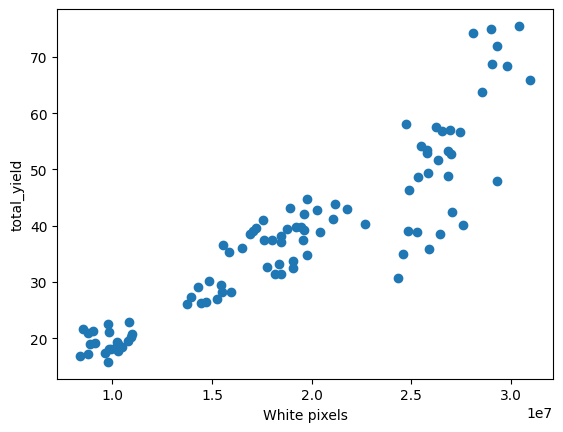

In [ ]:
plt.scatter(x = white, y = total_yield )
plt.xlabel('White pixels')
plt.ylabel('total_yield')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error



In [ ]:
white = np.array(white).reshape((-1,1))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(white,total_yield,test_size = 0.3,random_state = 56)

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
print(f'R2 score:{r2_score(y_test,y_pred)}')
print(f'MAE{mean_absolute_error(y_test,y_pred)}')

In [ ]:
slope = model.coef_[0]

In [ ]:
slope

2.06342830300154e-06

In [ ]:
os.makedirs('lr_plots',exist_ok = True)

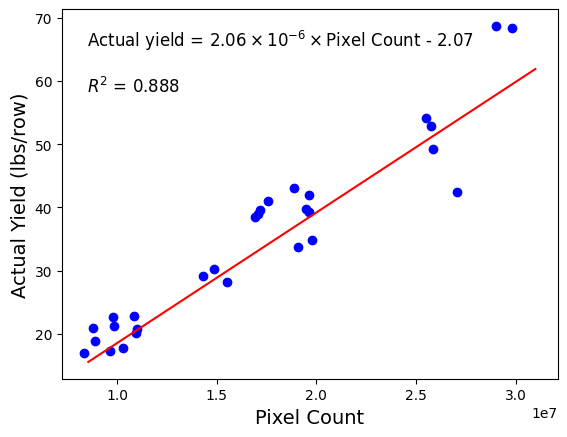

In [ ]:
x_range = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
y_range_pred = model.predict(x_range)

# Get the slope (m) and intercept (b) of the line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

plt.scatter(X_test, y_test, color='blue')  # Label the scatter plot
plt.plot(x_range, y_range_pred, color='red')  # Linear fit

# Labels for axes
plt.xlabel('Pixel Count', fontsize=14)
plt.ylabel('Actual Yield (lbs/row)', fontsize=14)

# Adding text with proper LaTeX formatting and ensuring sign of the intercept is correct
plt.text(0.05, 0.95,
         f'Actual yield = $2.06 \\times 10^{{-6}}\\times$Pixel Count {"-"} {abs(intercept):.2f}\n\n$R^2$ = {r_squared:.3f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Save and show plot
plt.savefig('lr_plots/linear_model_unet_att.png', dpi=300)
plt.show()
